In [7]:
import numpy as np
import cv2

def sharpen_image(image, kernel_size=(3, 3), strength=1.0):
    # Define sharpening kernel
    sharpen_kernel = np.array([[-1, -1, -1],
                               [-1,  9, -1],
                               [-1, -1, -1]])
    
    # Normalize kernel
    sharpen_kernel = sharpen_kernel / np.sum(sharpen_kernel)
    
    # Apply convolution with the sharpening kernel
    sharpened_image = cv2.filter2D(image, -1, sharpen_kernel)
    
    # Adjust strength
    sharpened_image = cv2.addWeighted(image, 1 + strength, sharpened_image, -strength, 0)
    
    return sharpened_image

# Load the image
image_path = 'sunflower.jpg'
image = cv2.imread(image_path)

# Convert image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply sharpening
sharpened_image = sharpen_image(gray_image)

# Display the original and sharpened images
cv2.imshow('Original Image', gray_image)
cv2.imshow('Sharpened Image', sharpened_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


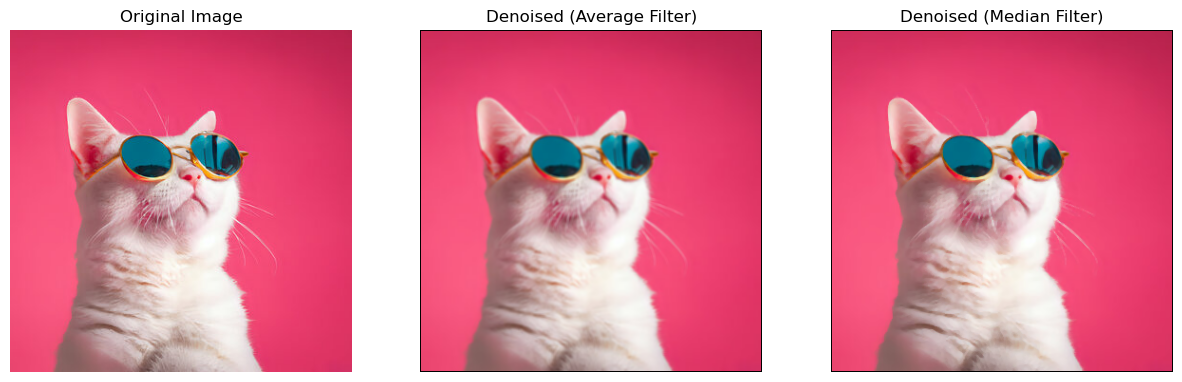

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def average_filter(image, kernel_size):
    height, width, channels = image.shape
    output = np.zeros((height, width, channels), dtype=np.uint8)
    k_half = kernel_size // 2
    
    for i in range(k_half, height - k_half):
        for j in range(k_half, width - k_half):
            for c in range(channels):
                sum = 0
                for m in range(-k_half, k_half + 1):
                    for n in range(-k_half, k_half + 1):
                        sum += image[i+m, j+n, c]
                output[i, j, c] = sum // (kernel_size ** 2)
    
    return output

def median_filter(image, kernel_size):
    height, width, channels = image.shape
    output = np.zeros((height, width, channels), dtype=np.uint8)
    k_half = kernel_size // 2
    
    for i in range(k_half, height - k_half):
        for j in range(k_half, width - k_half):
            for c in range(channels):
                neighbors = []
                for m in range(-k_half, k_half + 1):
                    for n in range(-k_half, k_half + 1):
                        neighbors.append(image[i+m, j+n, c])
                output[i, j, c] = np.median(neighbors)
    
    return output

# Load the image
image_path = 'sunflower.jpg'
image = np.array(Image.open(image_path))

# Remove noise using average filter
denoised_avg = average_filter(image, kernel_size=3)

# Remove noise using median filter
denoised_median = median_filter(image, kernel_size=3)

# Display the original and denoised images
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(denoised_avg)
plt.title('Denoised (Average Filter)')
plt.axis('off')

plt.subplot(133)
plt.imshow(denoised_median)
plt.title('Denoised (Median Filter)')
plt.axis('off')

plt.show()



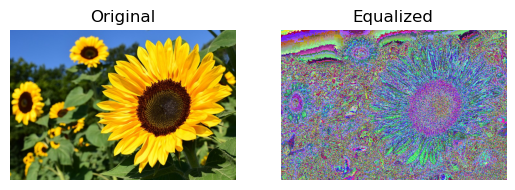

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def histogram_equalization_color(image):
    equalized_image = np.zeros_like(image)
    for i in range(3):  # Loop over RGB channels
        channel = image[:,:,i]
        # Compute histogram
        histogram, _ = np.histogram(channel.flatten(), bins=256, range=(0, 255))
        # Compute cumulative distribution function
        cdf = histogram.cumsum()
        cdf_normalized = cdf * histogram.max() / cdf.max()
        # Perform histogram equalization
        equalized_channel = np.interp(channel.flatten(), range(256), cdf_normalized).reshape(channel.shape)
        equalized_image[:,:,i] = equalized_channel
    return equalized_image.astype(np.uint8)

# Load the image
image = cv2.imread('sunflower.jpg')

# Plot the original image
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Perform histogram equalization on color image
equalized_image = histogram_equalization_color(image)

# Plot the equalized image
plt.subplot(1, 2, 2)
plt.title("Equalized")
plt.imshow(cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()



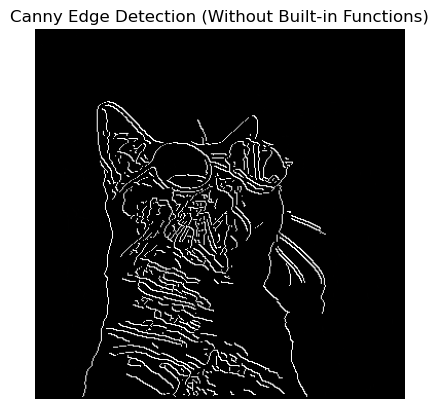

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_kernel(size, sigma=1):
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-size//2)**2 + (y-size//2)**2)/(2*sigma**2)), (size, size))
    return kernel / np.sum(kernel)

def convolve2d(image, kernel):
    kernel_size = kernel.shape[0]
    pad_width = kernel_size // 2
    padded_image = np.pad(image, pad_width, mode='constant', constant_values=0)
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            output[i, j] = np.sum(padded_image[i:i+kernel_size, j:j+kernel_size] * kernel)
    return output

def sobel_filters(image):
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    gradient_x = convolve2d(image, kernel_x)
    gradient_y = convolve2d(image, kernel_y)
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    angle = np.arctan2(gradient_y, gradient_x)
    return magnitude, angle

def non_maximum_suppression(magnitude, angle):
    suppressed = np.zeros_like(magnitude)
    angle = np.rad2deg(angle) % 180
    for i in range(1, magnitude.shape[0]-1):
        for j in range(1, magnitude.shape[1]-1):
            direction = angle[i, j]
            if (0 <= direction < 22.5) or (157.5 <= direction <= 180) or (22.5 <= direction < 67.5):
                neighbor1 = magnitude[i, j+1]
                neighbor2 = magnitude[i, j-1]
            elif (67.5 <= direction < 112.5) or (112.5 <= direction < 157.5):
                neighbor1 = magnitude[i+1, j-1]
                neighbor2 = magnitude[i-1, j+1]
            elif (112.5 <= direction < 157.5) or (157.5 <= direction <= 180) or (22.5 <= direction < 67.5):
                neighbor1 = magnitude[i+1, j]
                neighbor2 = magnitude[i-1, j]
            elif (67.5 <= direction < 112.5):
                neighbor1 = magnitude[i-1, j]
                neighbor2 = magnitude[i+1, j]
            if (magnitude[i, j] >= neighbor1) and (magnitude[i, j] >= neighbor2):
                suppressed[i, j] = magnitude[i, j]
    return suppressed

def double_thresholding(suppressed, low_threshold_ratio=0.05, high_threshold_ratio=0.09):
    high_threshold = suppressed.max() * high_threshold_ratio
    low_threshold = high_threshold * low_threshold_ratio
    weak = 25
    strong = 255
    strong_indices = suppressed >= high_threshold
    suppressed_indices = np.where((suppressed >= low_threshold) & (suppressed < high_threshold))
    suppressed[suppressed_indices] = weak
    suppressed[strong_indices] = strong
    return suppressed

def edge_tracking(image):
    weak = 25
    strong = 255
    rows, cols = image.shape
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if image[i, j] == weak:
                if ((image[i+1, j-1] == strong) or (image[i+1, j] == strong) or (image[i+1, j+1] == strong)
                    or (image[i, j-1] == strong) or (image[i, j+1] == strong)
                    or (image[i-1, j-1] == strong) or (image[i-1, j] == strong) or (image[i-1, j+1] == strong)):
                    image[i, j] = strong
                else:
                    image[i, j] = 0
    return image

# Read image from disk.
img = plt.imread('cat1.jpg').astype(float)

# Convert BGR image to grayscale
image_gray = np.mean(img, axis=2)

# Apply Gaussian blur
kernel_size = 5
sigma = 1.4
gaussian_kernel_array = gaussian_kernel(kernel_size, sigma)
blurred_image = convolve2d(image_gray, gaussian_kernel_array)

# Apply Sobel filters
magnitude, angle = sobel_filters(blurred_image)

# Perform non-maximum suppression
suppressed_image = non_maximum_suppression(magnitude, angle)

# Perform double thresholding
edge_image = double_thresholding(suppressed_image)

# Perform edge tracking by hysteresis
edge_image = edge_tracking(edge_image)

# Plot the result
plt.imshow(edge_image, cmap='gray')
plt.title('Canny Edge Detection (Without Built-in Functions)')
plt.axis('off')
plt.show()


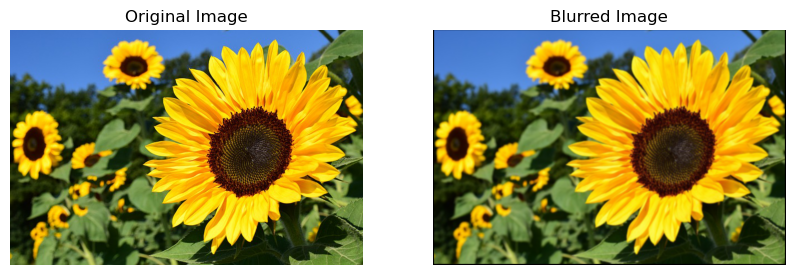

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_kernel(size, sigma=1):
    kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-size//2)**2 + (y-size//2)**2)/(2*sigma**2)), (size, size))
    return kernel / np.sum(kernel)

def convolution(image, kernel):
    m, n, _ = image.shape
    y, x = kernel.shape
    y = y // 2
    x = x // 2
    new_image = np.zeros_like(image)
    for i in range(y, m - y):
        for j in range(x, n - x):
            for k in range(image.shape[2]):  # Iterate over channels
                new_image[i, j, k] = np.sum(image[i-y:i+y+1, j-x:j+x+1, k] * kernel)
    return new_image

def blur_image(image, kernel_size):
    kernel = gaussian_kernel(kernel_size)
    blurred_image = convolution(image, kernel)
    return blurred_image

# Load the image
image = plt.imread('sunflower.jpg')

# Apply Gaussian blur
blurred_image = blur_image(image, kernel_size=5)

# Plot the original and blurred images
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Blurred image
plt.subplot(1, 2, 2)
plt.imshow(blurred_image.astype(np.uint8))
plt.title('Blurred Image')
plt.axis('off')

plt.show()

